In [1]:
import pandas as pd
import os
from scipy.io import loadmat
from pathlib import Path
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision.models import resnet18, ResNet18_Weights
from tqdm.notebook import tqdm
import json

import mlflow
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms.functional import to_pil_image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


https://stackoverflow.com/questions/52517176/stanford-cars-dataset-annotations-missed

In [2]:
mlflow.set_experiment("ResNet18_Image_Classification")

<Experiment: artifact_location='file:///Users/danielmak/Documents/HTX/mlruns/461932302175787790', creation_time=1733847862345, experiment_id='461932302175787790', last_update_time=1733847862345, lifecycle_stage='active', name='ResNet18_Image_Classification', tags={}>

In [3]:

# Directories and metadata
root_dir = Path('stanford-cars-dataset')
cars_test = root_dir / 'cars_test' / 'cars_test'
cars_train = root_dir / 'cars_train' / 'cars_train'

training_images = os.listdir(cars_train)
testing_images = os.listdir(cars_test)

root_dir = Path("standford-cars-dataset-meta/")
cars_annos_train = root_dir / "devkit" / "cars_train_annos.mat"
cars_annos_test = root_dir / "cars_test_annos_withlabels (1).mat"

cars_meta_mat = loadmat(root_dir / "devkit" / "cars_meta.mat") #dict_keys(['__header__', '__version__', '__globals__', 'class_names'])
cars_annos_train_mat, cars_annos_test_mat = loadmat(cars_annos_train), loadmat(cars_annos_test) #dict_keys(['__header__', '__version__', '__globals__', 'annotations'])



In [4]:
# Parse annotations into arrays for training and testing
def parse_annotations(annotations):
    bounding_boxes = []
    class_labels = []
    file_names = []
    
    for anno in annotations:
        x1 = anno['bbox_x1'][0][0]
        y1 = anno['bbox_y1'][0][0]
        x2 = anno['bbox_x2'][0][0]
        y2 = anno['bbox_y2'][0][0]
        class_id = anno['class'][0][0]
        file_name = anno['fname'][0]
        
        bounding_boxes.append((x1, y1, x2, y2))
        class_labels.append(class_id - 1)  # Adjust to 0-based indexing
        file_names.append(file_name)
    
    return np.array(bounding_boxes), np.array(class_labels), np.array(file_names)

# Parse training and test annotations
bounding_boxes_train, class_labels_train, file_names_train = parse_annotations(cars_annos_train_mat['annotations'][0])
bounding_boxes_test, class_labels_test, file_names_test = parse_annotations(cars_annos_test_mat['annotations'][0])

In [5]:
# cars_annos_train_mat.keys()
# annotations = cars_annos_train_mat['annotations'][0]

# # Initialize lists to store extracted data
# bounding_boxes = []
# class_labels = []
# file_names = []

# # Loop through each annotation
# for anno in annotations:
#     x1 = anno['bbox_x1'][0][0]
#     y1 = anno['bbox_y1'][0][0]
#     x2 = anno['bbox_x2'][0][0]
#     y2 = anno['bbox_y2'][0][0]
#     class_id = anno['class'][0][0]
#     file_name = anno['fname'][0]
    
#     # Append to lists
#     bounding_boxes.append((x1, y1, x2, y2))
#     class_labels.append(class_id)
#     file_names.append(file_name)

# # Convert to numpy arrays for easier manipulation
# bounding_boxes = np.array(bounding_boxes)
# class_labels = np.array(class_labels)
# file_names = np.array(file_names)

# print(f"First bounding box: {bounding_boxes[0]}")
# print(f"First class label: {class_labels[0]}")
# print(f"First file name: {file_names[0]}")


In [5]:
class_names = [arr[0] for arr in cars_meta_mat['class_names'][0]]
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

In [7]:
print(f"Number of training images: {len(file_names_train)}")
print(f"Number of test images: {len(file_names_test)}")

Number of training images: 8144
Number of test images: 8041


# Data Exploration

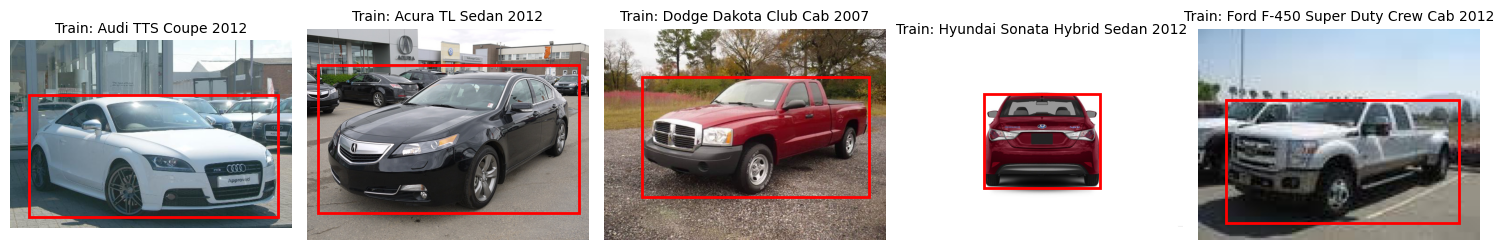

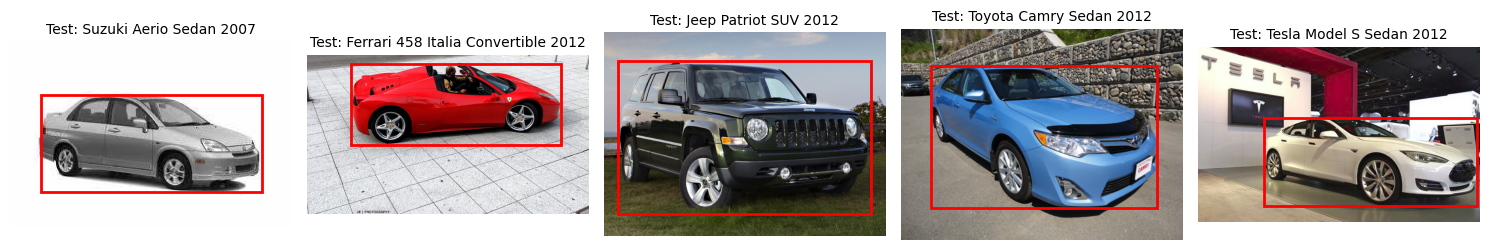

In [9]:
def plot_samples_with_bboxes(num_samples, annotations, class_names, cars_dir, dataset_type="train"):
    """
    Plot images with bounding boxes for training or test set.

    Args:
        num_samples (int): Number of samples to display.
        annotations (list): List of annotations for the dataset.
        class_names (list): List of car class names.
        cars_dir (Path or str): Path to the directory containing images.
        dataset_type (str): "train" or "test", for labeling the dataset.
    """
    plt.figure(figsize=(15, 10))  # Adjust figure size for clarity
    
    for i in range(num_samples):
        # Get annotation details
        annotation = annotations[i]
        x1 = annotation['bbox_x1'][0][0]
        y1 = annotation['bbox_y1'][0][0]
        x2 = annotation['bbox_x2'][0][0]
        y2 = annotation['bbox_y2'][0][0]
        class_id = annotation['class'][0][0]
        file_name = annotation['fname'][0]
        car_name = class_names[class_id - 1]  # Map class ID to car name

        # Load the image
        img_path = Path(cars_dir) / file_name
        if not img_path.exists():
            print(f"Warning: {file_name} does not exist in {cars_dir}. Skipping.")
            continue
        with Image.open(img_path) as img:
            # Plot image
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                              edgecolor='red', facecolor='none', linewidth=2))
            plt.title(f"{dataset_type.capitalize()}: {car_name}", fontsize=10)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Parameters
num_samples = 5  # Number of samples to display

# Plot training samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_train_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_train,
    dataset_type="train"
)

# Plot test samples
plot_samples_with_bboxes(
    num_samples=num_samples,
    annotations=cars_annos_test_mat['annotations'][0],
    class_names=[name[0] for name in cars_meta_mat['class_names'][0]],
    cars_dir=cars_test,
    dataset_type="test"
)


Top 5 Train Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Chrysler 300 SRT-8 2010                     49
Mercedes-Benz 300-Class Convertible 1993    48
Mitsubishi Lancer Sedan 2012                48
Jaguar XK XKR 2012                          47
Name: count, dtype: int64
Bottom 5 Train Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


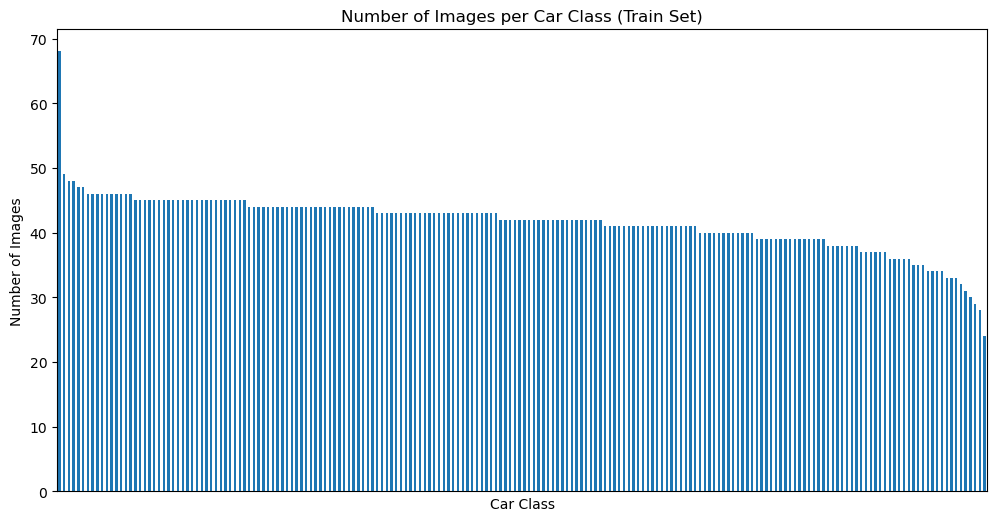

Top 5 Test Classes and Frequency:
class_name
GMC Savana Van 2012                         68
Mercedes-Benz 300-Class Convertible 1993    48
Chrysler 300 SRT-8 2010                     48
Mitsubishi Lancer Sedan 2012                47
Chevrolet Corvette ZR1 2012                 46
Name: count, dtype: int64
Bottom 5 Test Classes and Frequency:
class_name
Rolls-Royce Phantom Drophead Coupe Convertible 2012    30
Maybach Landaulet Convertible 2012                     29
Chevrolet Express Cargo Van 2007                       29
FIAT 500 Abarth 2012                                   27
Hyundai Accent Sedan 2012                              24
Name: count, dtype: int64


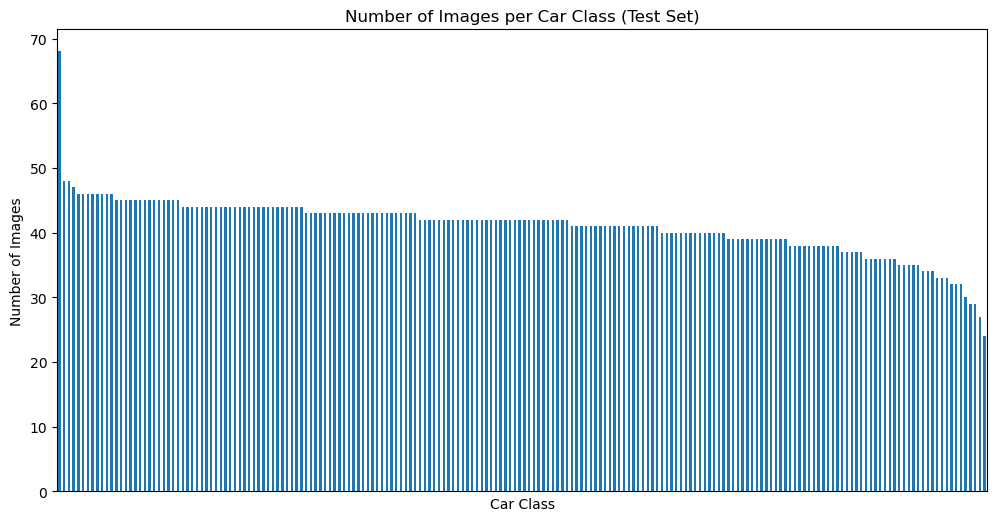

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def get_class_distribution(annotations, class_names):
    """
    Extract class distribution from annotations.
    
    Args:
        annotations (list): List of annotations (train or test).
        class_names (list): List of class names.
    
    Returns:
        pd.DataFrame: DataFrame with file names, bounding box info, class IDs, and class names.
        pd.Series: Class distribution counts.
    """
    data = []
    for anno in annotations:
        x1 = anno['bbox_x1'][0][0]
        y1 = anno['bbox_y1'][0][0]
        x2 = anno['bbox_x2'][0][0]
        y2 = anno['bbox_y2'][0][0]
        class_id = anno['class'][0][0]
        file_name = anno['fname'][0]
        data.append([file_name, x1, y1, x2, y2, class_id, class_names[class_id - 1]])
    
    df = pd.DataFrame(data, columns=['file_name', 'x1', 'y1', 'x2', 'y2', 'class_id', 'class_name'])
    class_counts = df['class_name'].value_counts()
    return df, class_counts

def plot_class_distribution(class_counts, dataset_type="train"):
    """
    Plot class distribution as a bar chart.
    
    Args:
        class_counts (pd.Series): Class distribution counts.
        dataset_type (str): "train" or "test", for labeling the dataset.
    """
    plt.figure(figsize=(12, 6))
    class_counts.plot(kind='bar')
    plt.title(f"Number of Images per Car Class ({dataset_type.capitalize()} Set)")
    plt.xlabel("Car Class")
    plt.ylabel("Number of Images")
    plt.xticks([])
    plt.show()

# Analyze train set
df_train, class_counts_train = get_class_distribution(
    cars_annos_train_mat['annotations'][0],
    [name[0] for name in cars_meta_mat['class_names'][0]]
)
print("Top 5 Train Classes and Frequency:")
print(class_counts_train.head(5))
print("Bottom 5 Train Classes and Frequency:")
print(class_counts_train.tail(5))
plot_class_distribution(class_counts_train, dataset_type="train")

# Analyze test set
df_test, class_counts_test = get_class_distribution(
    cars_annos_test_mat['annotations'][0],
    [name[0] for name in cars_meta_mat['class_names'][0]]
)
print("Top 5 Test Classes and Frequency:")
print(class_counts_test.head(5))
print("Bottom 5 Test Classes and Frequency:")
print(class_counts_test.tail(5))
plot_class_distribution(class_counts_test, dataset_type="test")


Average Bounding Box Area Ratio (Train): 0.3695842059366587


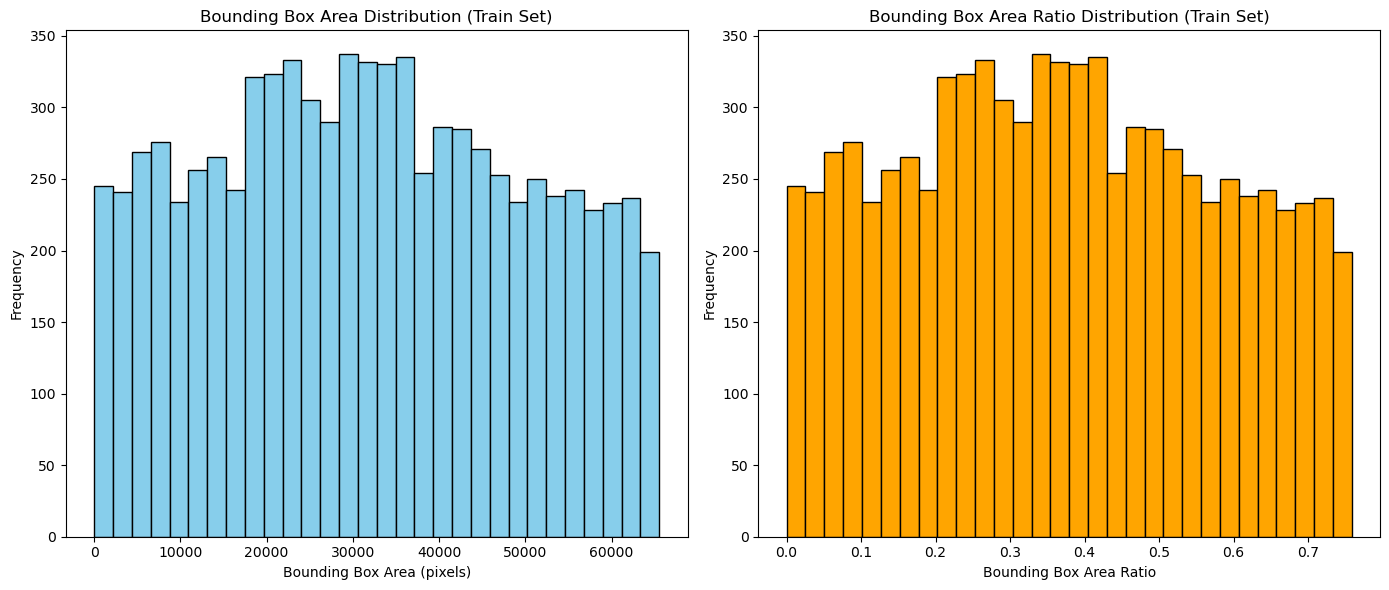

Average Bounding Box Area Ratio (Test): 0.37179012249720184


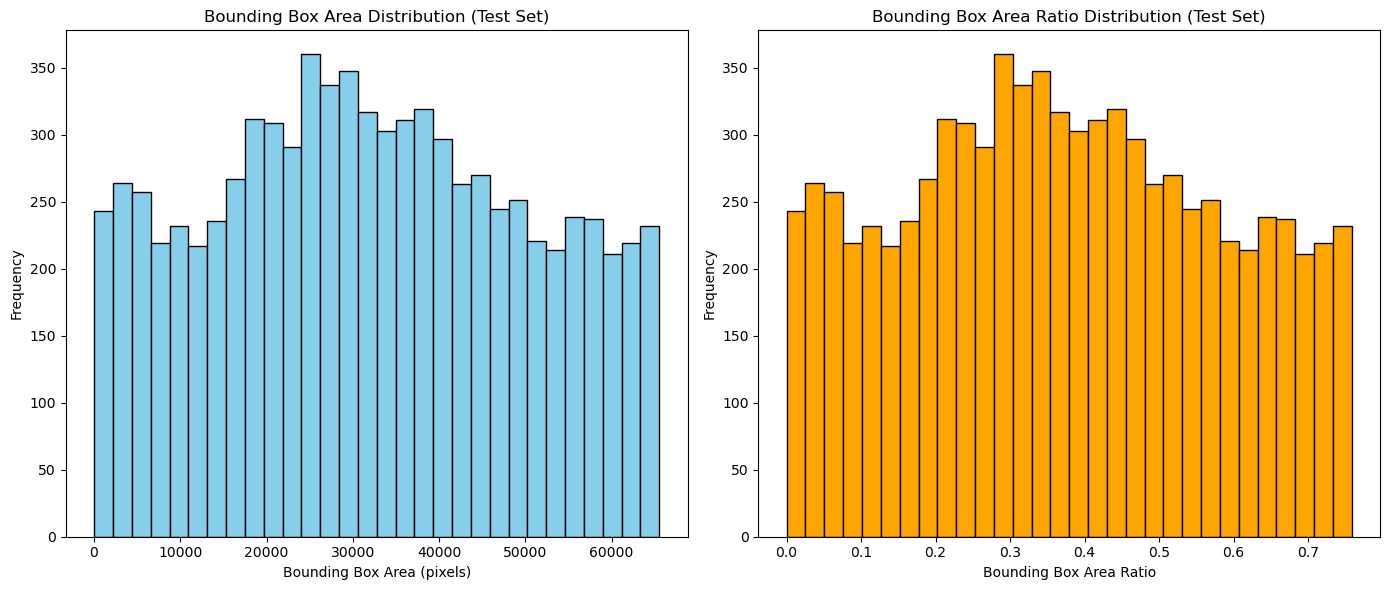

In [11]:
def calculate_bounding_box_stats(df, image_width=360, image_height=240):
    """
    Calculate bounding box statistics and add columns to the DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing bounding box annotations.
        image_width (int): Fixed width of the images.
        image_height (int): Fixed height of the images.
    
    Returns:
        pd.DataFrame: Updated DataFrame with additional columns for bounding box stats.
        float: Average bounding box area ratio.
    """
    df['bbox_width'] = df['x2'] - df['x1']
    df['bbox_height'] = df['y2'] - df['y1']
    df['bbox_area'] = df['bbox_width'] * df['bbox_height']
    df['image_area'] = image_width * image_height
    df['bbox_area_ratio'] = df['bbox_area'] / df['image_area']
    average_bbox_ratio = df['bbox_area_ratio'].mean()
    return df, average_bbox_ratio

def plot_bounding_box_distributions(df, dataset_type="train"):
    """
    Plot bounding box area and area ratio distributions.
    
    Args:
        df (pd.DataFrame): DataFrame containing bounding box stats.
        dataset_type (str): "train" or "test", for labeling the plots.
    """
    plt.figure(figsize=(14, 6))

    # Bounding box area distribution
    plt.subplot(1, 2, 1)
    plt.hist(df['bbox_area'], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Bounding Box Area Distribution ({dataset_type.capitalize()} Set)")
    plt.xlabel("Bounding Box Area (pixels)")
    plt.ylabel("Frequency")

    # Bounding box area ratio distribution
    plt.subplot(1, 2, 2)
    plt.hist(df['bbox_area_ratio'], bins=30, color='orange', edgecolor='black')
    plt.title(f"Bounding Box Area Ratio Distribution ({dataset_type.capitalize()} Set)")
    plt.xlabel("Bounding Box Area Ratio")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Process train dataset
df_train_stats, avg_bbox_ratio_train = calculate_bounding_box_stats(df_train)
print(f"Average Bounding Box Area Ratio (Train): {avg_bbox_ratio_train}")
plot_bounding_box_distributions(df_train_stats, dataset_type="train")

# Process test dataset
df_test_stats, avg_bbox_ratio_test = calculate_bounding_box_stats(df_test)
print(f"Average Bounding Box Area Ratio (Test): {avg_bbox_ratio_test}")
plot_bounding_box_distributions(df_test_stats, dataset_type="test")


The Dataset consist of Images that are 86,400 Pixels area. (360 pixels × 240 pixels)
-

## Cropping the images with the bounding boxes

In [6]:
# Create output directories for cropped images
cropped_train_dir = Path('cropped_train')
cropped_train_dir.mkdir(parents=True, exist_ok=True)
cropped_test_dir = Path('cropped_test')
cropped_test_dir.mkdir(parents=True, exist_ok=True)

In [ ]:

# Function to crop and save images
def crop_and_save_images(file_names, bounding_boxes, source_dir, target_dir):
    for i, bbox in tqdm(enumerate(bounding_boxes), total=len(bounding_boxes)):
        file_name = file_names[i]
        x1, y1, x2, y2 = bbox
        
        # Load image
        img_path = source_dir / file_name
        if not img_path.exists():
            print(f"Warning: {img_path} does not exist.")
            continue
        with Image.open(img_path) as img:
            # Crop image
            cropped_img = img.crop((x1, y1, x2, y2))
            # Save cropped image
            cropped_img.save(target_dir / file_name)

# Crop and save training images
crop_and_save_images(file_names_train, bounding_boxes_train, cars_train, cropped_train_dir)

# Crop and save test images
crop_and_save_images(file_names_test, bounding_boxes_test, cars_test, cropped_test_dir)

print(f"Cropped training images saved to: {cropped_train_dir}")
print(f"Cropped test images saved to: {cropped_test_dir}")

  0%|          | 0/8144 [00:00<?, ?it/s]

  0%|          | 0/8041 [00:00<?, ?it/s]

Cropped training images saved to: cropped_train
Cropped test images saved to: cropped_test


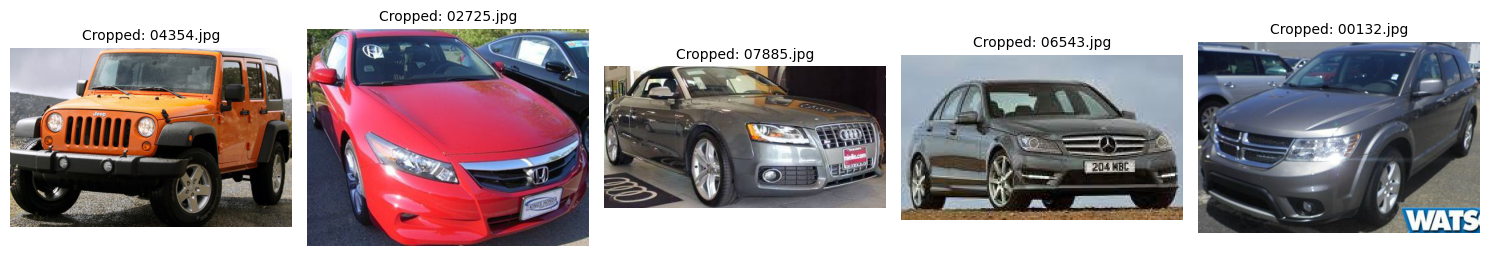

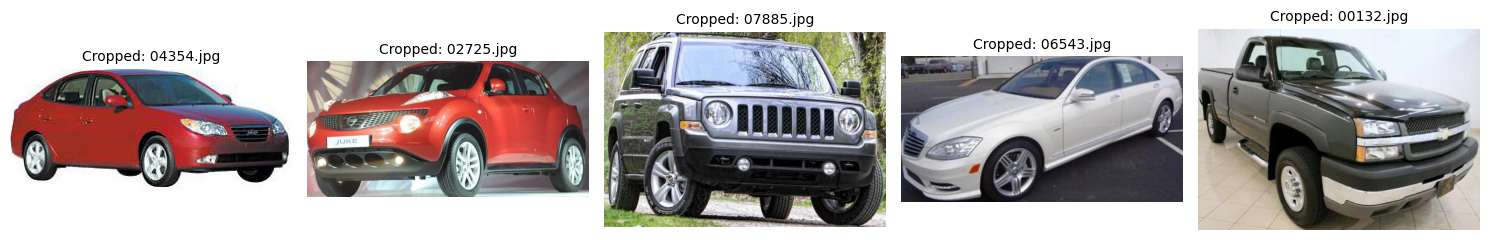

In [7]:
# Function to display a few cropped images for verification
def display_cropped_images(cropped_dir, num_images=5):
    cropped_files = list(cropped_dir.iterdir())[:num_images]
    plt.figure(figsize=(15, 10))
    for i, file_path in enumerate(cropped_files):
        img = Image.open(file_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Cropped: {file_path.name}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some cropped training images
display_cropped_images(cropped_train_dir, num_images=5)

# Display some cropped test images
display_cropped_images(cropped_test_dir, num_images=5)


## Problem Analysis and Critical Thinking

1) Bounding boxes in the dataset suggest an opportunity for pre-processing using localization techniques.
- Will be asessing whether cropping the image with the bounding boxes meaningfully improve the classification model's performance

2) Since car images might vary in real-world scenarios (low-light, partial occlusions), there might be a need to use data augmentation strategies to simulate these scenarios

3) Usage of object detection models for integrated car locatlization and type classification

4) Security Considerations:
- Highlight strategies to secure the API:
- Add rate limiting to prevent abuse.
- Validate input files to avoid malicious uploads.
Use HTTPS and authentication tokens.

cars_meta.mat contains a nested dictionary with Metadata information on the date the file was created. the class_names attribute contains all the names of the car labels

In [8]:


# Parse annotations into dictionaries
training_image_label_dict, testing_image_label_dict = {}, {}

for arr in cars_annos_train_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    training_image_label_dict[image] = label

for arr in cars_annos_test_mat['annotations'][0]:
    image, label = arr[-1][0], arr[-2][0][0] - 1
    testing_image_label_dict[image] = label

In [9]:
testing_image_label_dict

{'00001.jpg': 180,
 '00002.jpg': 102,
 '00003.jpg': 144,
 '00004.jpg': 186,
 '00005.jpg': 184,
 '00006.jpg': 77,
 '00007.jpg': 117,
 '00008.jpg': 164,
 '00009.jpg': 31,
 '00010.jpg': 59,
 '00011.jpg': 48,
 '00012.jpg': 107,
 '00013.jpg': 115,
 '00014.jpg': 134,
 '00015.jpg': 82,
 '00016.jpg': 50,
 '00017.jpg': 153,
 '00018.jpg': 32,
 '00019.jpg': 21,
 '00020.jpg': 31,
 '00021.jpg': 150,
 '00022.jpg': 3,
 '00023.jpg': 80,
 '00024.jpg': 106,
 '00025.jpg': 164,
 '00026.jpg': 190,
 '00027.jpg': 169,
 '00028.jpg': 194,
 '00029.jpg': 90,
 '00030.jpg': 4,
 '00031.jpg': 163,
 '00032.jpg': 147,
 '00033.jpg': 187,
 '00034.jpg': 43,
 '00035.jpg': 32,
 '00036.jpg': 6,
 '00037.jpg': 30,
 '00038.jpg': 73,
 '00039.jpg': 29,
 '00040.jpg': 165,
 '00041.jpg': 179,
 '00042.jpg': 105,
 '00043.jpg': 2,
 '00044.jpg': 64,
 '00045.jpg': 190,
 '00046.jpg': 34,
 '00047.jpg': 74,
 '00048.jpg': 84,
 '00049.jpg': 24,
 '00050.jpg': 167,
 '00051.jpg': 136,
 '00052.jpg': 133,
 '00053.jpg': 190,
 '00054.jpg': 155,
 '0

# Load Data

In [10]:
# Define custom dataset class
class StanfordCarsDataset(Dataset):
    def __init__(self, image_label_dict, root_dir, transform=None):
        self.image_label_dict = image_label_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_label_dict)

    def __getitem__(self, idx):
        image_filename = list(self.image_label_dict.keys())[idx]
        label = self.image_label_dict[image_filename]
        image_path = self.root_dir / image_filename
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Use ResNet-18's transformation parameters
weights = ResNet18_Weights.DEFAULT
transform = weights.transforms()

# Instantiate datasets and dataloaders
train_dataset = StanfordCarsDataset(training_image_label_dict, cropped_train_dir, transform=transform)
test_dataset = StanfordCarsDataset(testing_image_label_dict, cropped_test_dir, transform=transform)

# Model Architecture

In [12]:
batch_size = 32
dropout_rate = 0.3
learning_rate = 0.001
dropout = 0.5

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load pre-trained ResNet-18 model
model = resnet18(weights=weights)
# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = nn.Linear(model.fc.in_features, len(class_names))  # Replace final layer with 196 classes

model.fc = nn.Sequential(
    nn.Dropout(p=dropout),  # Apply 50% dropout
    nn.Linear(model.fc.in_features, len(class_names))  # Output layer
)

# Ensure the new fc layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Transfer model to device
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)
model = model.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Parameterize the optimizer
optimizer_name = optimizer.__class__.__name__

mps


In [14]:
# Hyperparameter grid
# learning_rates = [0.001, 0.0001]
# batch_sizes = [16, 32]
# optimizers = ['Adam', 'SGD']

# Architecture log
architecture_description = "ResNet-18 with Classification Head 1 freeze extractor layers(Baseline)"

'ResNet18'

'Adam'

0.001

32

40

'ResNet-18 with Classification Head 1 freeze extractor layers(Baseline)'

True

True

0.5

3

4714

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/40], Train Loss: 5.3584, Train Accuracy: 1.67%, Val Loss: 4.5783, Val Accuracy: 9.64%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 2/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [2/40], Train Loss: 4.4723, Train Accuracy: 8.87%, Val Loss: 4.0972, Val Accuracy: 17.30%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 3/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [3/40], Train Loss: 4.0154, Train Accuracy: 14.73%, Val Loss: 3.8298, Val Accuracy: 19.40%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 4/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [4/40], Train Loss: 3.7557, Train Accuracy: 17.95%, Val Loss: 3.6331, Val Accuracy: 22.99%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 5/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [5/40], Train Loss: 3.5321, Train Accuracy: 22.03%, Val Loss: 3.4720, Val Accuracy: 25.62%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 6/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [6/40], Train Loss: 3.3764, Train Accuracy: 24.57%, Val Loss: 3.3618, Val Accuracy: 26.90%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 7/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [7/40], Train Loss: 3.2639, Train Accuracy: 25.60%, Val Loss: 3.2417, Val Accuracy: 28.64%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 8/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [8/40], Train Loss: 3.2024, Train Accuracy: 26.77%, Val Loss: 3.2272, Val Accuracy: 28.32%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 9/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [9/40], Train Loss: 3.1606, Train Accuracy: 27.75%, Val Loss: 3.1343, Val Accuracy: 30.11%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 10/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [10/40], Train Loss: 3.0715, Train Accuracy: 29.26%, Val Loss: 3.0888, Val Accuracy: 30.79%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 11/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [11/40], Train Loss: 3.0419, Train Accuracy: 29.40%, Val Loss: 3.0605, Val Accuracy: 31.02%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 12/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [12/40], Train Loss: 3.0060, Train Accuracy: 29.89%, Val Loss: 3.0242, Val Accuracy: 31.79%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 13/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [13/40], Train Loss: 2.9742, Train Accuracy: 30.77%, Val Loss: 2.9982, Val Accuracy: 32.55%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 14/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [14/40], Train Loss: 2.9552, Train Accuracy: 30.72%, Val Loss: 2.9752, Val Accuracy: 32.47%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 15/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [15/40], Train Loss: 2.9148, Train Accuracy: 30.89%, Val Loss: 2.9384, Val Accuracy: 33.25%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 16/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [16/40], Train Loss: 2.9288, Train Accuracy: 31.11%, Val Loss: 2.9340, Val Accuracy: 32.86%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 17/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [17/40], Train Loss: 2.9276, Train Accuracy: 31.73%, Val Loss: 2.9558, Val Accuracy: 31.43%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 18/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [18/40], Train Loss: 2.8870, Train Accuracy: 32.39%, Val Loss: 2.8877, Val Accuracy: 34.47%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 19/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [19/40], Train Loss: 2.9079, Train Accuracy: 32.00%, Val Loss: 2.9224, Val Accuracy: 33.13%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 20/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [20/40], Train Loss: 2.8782, Train Accuracy: 32.23%, Val Loss: 2.9084, Val Accuracy: 33.30%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 21/40:   0%|          | 0/255 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [21/40], Train Loss: 2.9045, Train Accuracy: 31.81%, Val Loss: 2.8895, Val Accuracy: 33.58%
Early stopping triggered at epoch 21


<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Loss vs Epochs')

<Axes: >

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Accuracy vs Epochs')

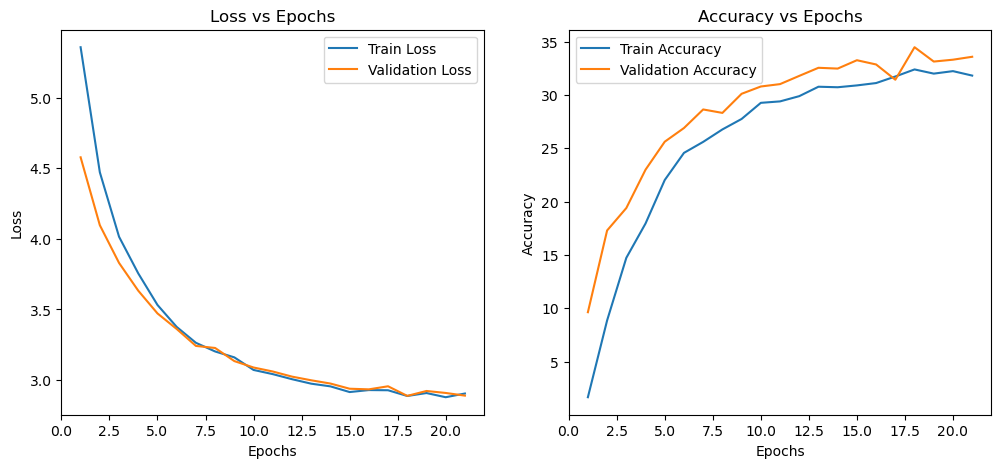

In [15]:
# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 0.01  # Minimum change to qualify as improvement
best_val_loss = float('inf')  # Best validation loss observed
wait = 0  # Counter for patience

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40

if mlflow.active_run():
    mlflow.end_run()
with mlflow.start_run(run_name=architecture_description):
    # Log model parameters
    mlflow.log_param("model", "ResNet18")
    mlflow.log_param("optimizer", optimizer_name)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("architecture", architecture_description)
    mlflow.log_param("use_cropped_images", True)
    mlflow.log_param("freeze_extractor_layers", True)
    mlflow.log_param("Dropout", dropout)
    mlflow.log_param("patience", patience)

    # Save the model structure
    model_structure = str(model)
    with open(f"{architecture_description}.txt", "w") as f:
        f.write(model_structure)
    mlflow.log_artifact(f"{architecture_description}.txt", artifact_path="model_architecture")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar with loss
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Log training metrics to MLflow
        mlflow.log_metric("train_loss", train_loss, step=epoch + 1)
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch + 1)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(test_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Log validation metrics to MLflow
        mlflow.log_metric("val_loss", val_loss, step=epoch + 1)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch + 1)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Check for early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            wait = 0  # Reset patience counter
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                mlflow.set_tag("early_stopping", f"Triggered at epoch {epoch + 1}")
                break

    # Plot training and validation loss/accuracy
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.show()
    # Save the plot
    plot_path = "learning_curve.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path, artifact_path="plots")  # Log the plot to MLflow
    plt.close()


In [ ]:
## Do some sample predictions and check the output against my image. 
## Rent collab to speed up model training with GPUs. Research ways to improve the model
## Commit code into Github with the commits. 
## Test out the docker file on mac docker engine. 

## Precision Recall and PR Curve

In [5]:
# Save the fine-tuned model
torch.save(model.state_dict(), "resnet18_finetuned_Adam_lr0.001_bs32_epoch5_10Dec_v1.pth")

In [30]:
for name, param in model.named_parameters():
    print(f"{name} requires_grad: {param.requires_grad}")

conv1.weight requires_grad: True
bn1.weight requires_grad: True
bn1.bias requires_grad: True
layer1.0.conv1.weight requires_grad: True
layer1.0.bn1.weight requires_grad: True
layer1.0.bn1.bias requires_grad: True
layer1.0.conv2.weight requires_grad: True
layer1.0.bn2.weight requires_grad: True
layer1.0.bn2.bias requires_grad: True
layer1.1.conv1.weight requires_grad: True
layer1.1.bn1.weight requires_grad: True
layer1.1.bn1.bias requires_grad: True
layer1.1.conv2.weight requires_grad: True
layer1.1.bn2.weight requires_grad: True
layer1.1.bn2.bias requires_grad: True
layer2.0.conv1.weight requires_grad: True
layer2.0.bn1.weight requires_grad: True
layer2.0.bn1.bias requires_grad: True
layer2.0.conv2.weight requires_grad: True
layer2.0.bn2.weight requires_grad: True
layer2.0.bn2.bias requires_grad: True
layer2.0.downsample.0.weight requires_grad: True
layer2.0.downsample.1.weight requires_grad: True
layer2.0.downsample.1.bias requires_grad: True
layer2.1.conv1.weight requires_grad: True


In [6]:
import torch
print(torch.backends.mps.is_available())

True


In [8]:
torch.device("mps" if torch.mps.is_available() else "cpu")

device(type='mps')